In [13]:
import pandas as pd
import numpy as np

import json
import joblib 
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder

import matplotlib.pyplot as plt
import seaborn as sns

from prophet import Prophet 


import warnings
warnings.filterwarnings("ignore")

/home/nuh/Desktop/StockAgentExample/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Importing plotly failed. Interactive plots will not work.


In [1]:
RAW_DATA_PATH = "/home/nuh/PycharmProjects/StockAgent/data"
DATA_PATH = "/home/nuh/PycharmProjects/StockAgent/dev_v_04/data"
MODEL_PATH = "/home/nuh/PycharmProjects/StockAgent/dev_v_04/models"

# Forecasting

## XGBoost Forecasting

In [28]:
import pandas as pd
import numpy as np
import joblib

def forecast_xgboost_total(
    product_id: int,
    model_path: str,
    product_df_path: str,
    start_date: str,
    end_date: str
) -> pd.DataFrame:
    """
    Gelecekteki belirli bir tarih aralığı için XGBoost ile varyant bazlı tahmin üretir.
    Eğitimde kullanılan tüm feature'ları içerir.
    """

    # 1. Modeli yükle
    model = joblib.load('/home/nuh/Desktop/StockAgentExample/models/sklearn/xgboost_model_product_7.pkl')

    # 2. Ürün varyantlarını yükle
    product_df = pd.read_csv(product_df_path)
    df = product_df[product_df["product_id"] == product_id].copy()

    # Gereken alanlar varsa ekle
    df["channel"] = "Toplam"
    df["type"] = "Standart"

    # Kategorik encoding
    for col in ["color", "size", "channel", "category", "subcategory", "type"]:
        df[col] = df[col].astype("category").cat.codes

    # 3. Geleceğe ait tarih aralığını oluştur
    forecast_rows = []
    dates = pd.date_range(start=start_date, end=end_date)

    for date in dates:
        dow = date.dayofweek
        month = date.month
        week = date.isocalendar().week

        for _, row in df.iterrows():
            forecast_rows.append({
                "color": row["color"],
                "size": row["size"],
                "channel": row["channel"],
                "category": row["category"],
                "subcategory": row["subcategory"],
                "type": row["type"],
                "is_campaign": 0,
                "discount": 0.0,
                "dayofweek_sin": np.sin(2 * np.pi * dow / 7),
                "dayofweek_cos": np.cos(2 * np.pi * dow / 7),
                "month_sin": np.sin(2 * np.pi * month / 12),
                "month_cos": np.cos(2 * np.pi * month / 12),
                "week_sin": np.sin(2 * np.pi * week / 52),
                "week_cos": np.cos(2 * np.pi * week / 52),
                "ds": date,
                "product_id": product_id,
                "color_str": row["color"],   # optional: for output
                "size_str": row["size"]
            })

    input_df = pd.DataFrame(forecast_rows)

    # 4. Tahmin yap
    X = input_df[[
        "color", "size", "channel", "category", "subcategory", "type",
        "is_campaign", "discount",
        "dayofweek_sin", "dayofweek_cos", "month_sin", "month_cos", "week_sin", "week_cos"
    ]]
    
    input_df["y_pred"] = model.predict(X)
    input_df["model"] = "XGBoost"

    return input_df[["ds", "product_id", "color_str", "size_str", "y_pred", "model"]].rename(
        columns={"color_str": "color", "size_str": "size"}
    )


In [4]:
df_forecast = forecast_xgboost_total(
    product_id=7,
    model_path=f"{MODEL_PATH}/sklearn/xgboost_model_product_7.pkl",
    product_df_path=f"{DATA_PATH}/products_with_variants.csv",
    start_date="2025-05-01",
    end_date="2025-05-07"
)

print(df_forecast.head())


          ds  product_id  color  size     y_pred    model
0 2025-05-01           7      2     2  11.192451  XGBoost
1 2025-05-01           7      2     0   9.636548  XGBoost
2 2025-05-01           7      2     1  10.537520  XGBoost
3 2025-05-01           7      1     2  10.699416  XGBoost
4 2025-05-01           7      1     0   8.102986  XGBoost


### Visualize The Forecasting

In [5]:

def decode_forecast_labels(df: pd.DataFrame, product_id: int) -> pd.DataFrame:
    """
    Tahmin çıktısındaki encode edilmiş color ve size etiketlerini çözümleyip okunabilir hale getirir.
    Varsayılan olarak encoder'lar models/sklearn/label_encoders_product_{product_id}.pkl içinden yüklenir.
    """
    # 🔐 Encoder dosyasının yolu
    encoder_color_path = f"{MODEL_PATH}/sklearn/xgboost_label_encoder_color.pkl"
    encoder_size_path = f"{MODEL_PATH}/sklearn/xgboost_label_encoder_size.pkl"
    
    # ✅ Yükle
    label_color_encoders = joblib.load(encoder_color_path)
    label_size_encoders = joblib.load(encoder_size_path)
    
    # 🔁 Kopya DataFrame üzerinde işlem
    df = df.copy()
    df["color_name"] = label_color_encoders.inverse_transform(df["color"])
    df["size_name"] = label_size_encoders.inverse_transform(df["size"])
    
    return df


In [6]:
def summarize_forecast(df: pd.DataFrame):
    """
    Her beden ve renk için toplam tahminleri haftalık olarak özetler.
    """
    summary = df.groupby(["color_name", "size_name"])["y_pred"].sum().reset_index()
    summary = summary.sort_values("y_pred", ascending=False)
    print("\n🔎 Toplam Tahmin (7 Günlük):")
    display(summary)
    return summary


In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

def plot_forecast(df: pd.DataFrame, product_id: int):
    """
    Tahminleri detaylı şekilde görselleştirir:
    1. Günlük toplam tahmin
    2. Renk bazlı toplam günlük satış
    3. Beden bazlı toplam günlük satış
    """
    
    # — 1. Günlük Toplam Tahmin (Tüm varyantlar birlikte) —
    daily_total = df.groupby("ds")["y_pred"].sum().reset_index()

    plt.figure(figsize=(10, 5))
    plt.plot(daily_total["ds"], daily_total["y_pred"], marker='o', linestyle='-', color='darkblue')
    plt.title(f"📦 Ürün {product_id} - Günlük Toplam Tahmini Satış", fontsize=13)
    plt.xlabel("Tarih")
    plt.ylabel("Tahmini Toplam Satış")
    plt.grid(True)
    plt.tight_layout()
    plt.show()


  
    # — 2. Renk Bazlı Günlük Toplam Tahmin —
    plt.figure(figsize=(10, 5))
    for color in df["color_name"].unique():
        daily = df[df["color_name"] == color].groupby("ds")["y_pred"].sum().reset_index()
        plt.plot(daily["ds"], daily["y_pred"], marker='o', label=color)

    plt.title(f"🎨 Ürün {product_id} - Renk Bazlı Günlük Tahmin (Toplam)", fontsize=13)
    plt.xlabel("Tarih")
    plt.ylabel("Tahmini Toplam Satış")
    plt.grid(True)
    plt.legend(title="Renk")
    plt.tight_layout()
    plt.show()

    # — 3. Beden Bazlı Günlük Toplam Tahmin —
    plt.figure(figsize=(10, 5))
    for size in df["size_name"].unique():
        daily = df[df["size_name"] == size].groupby("ds")["y_pred"].sum().reset_index()
        plt.plot(daily["ds"], daily["y_pred"], marker='o', label=size)

    plt.title(f"📏 Ürün {product_id} - Beden Bazlı Günlük Tahmin (Toplam)", fontsize=13)
    plt.xlabel("Tarih")
    plt.ylabel("Tahmini Toplam Satış")
    plt.grid(True)
    plt.legend(title="Beden")
    plt.tight_layout()
    plt.show()

    


🔎 Toplam Tahmin (7 Günlük):


,color_name,size_name,y_pred
1,Kırmızı,S,93.705704
4,Mavi,S,89.276466
2,Kırmızı,XL,84.451630
7,Siyah,S,83.947639
5,Mavi,XL,80.522766
8,Siyah,XL,79.657433
0,Kırmızı,M,76.996246
6,Siyah,M,73.217850
3,Mavi,M,72.399689



🔎 Toplam Urün Satış Tablo: 735



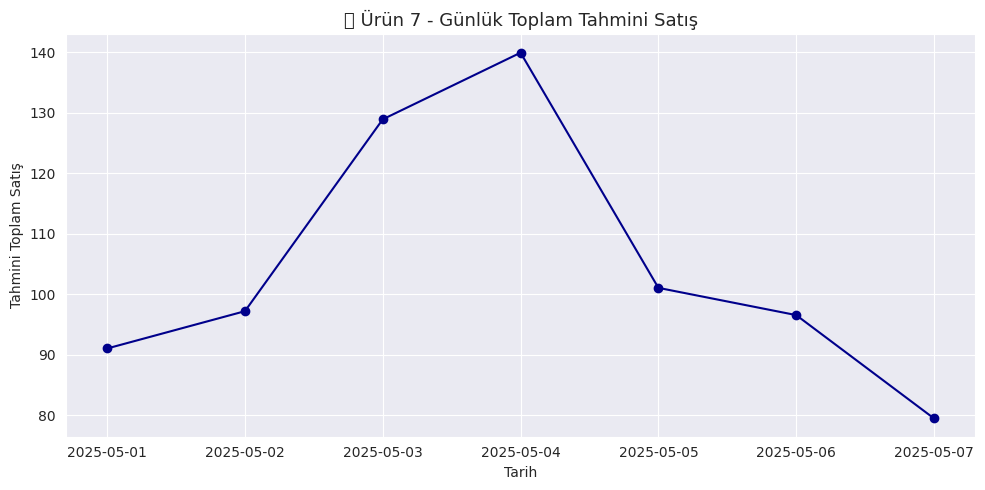

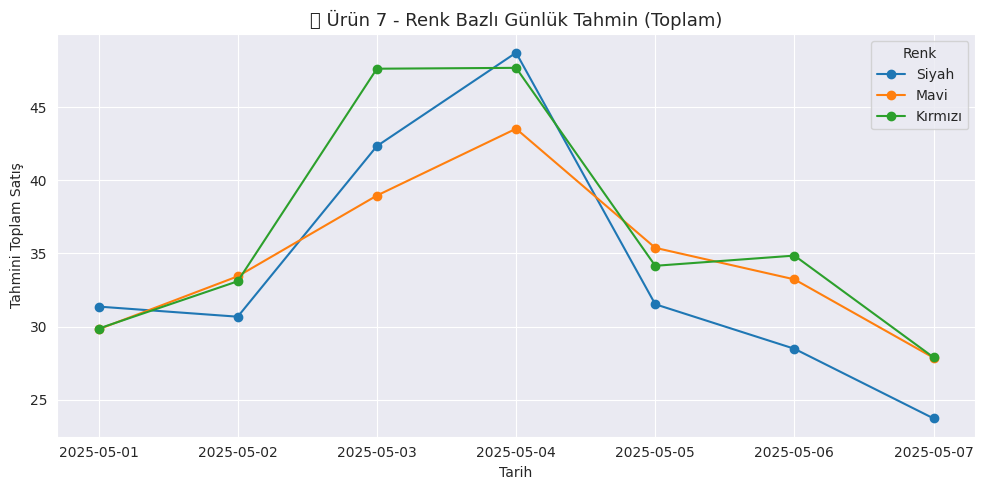

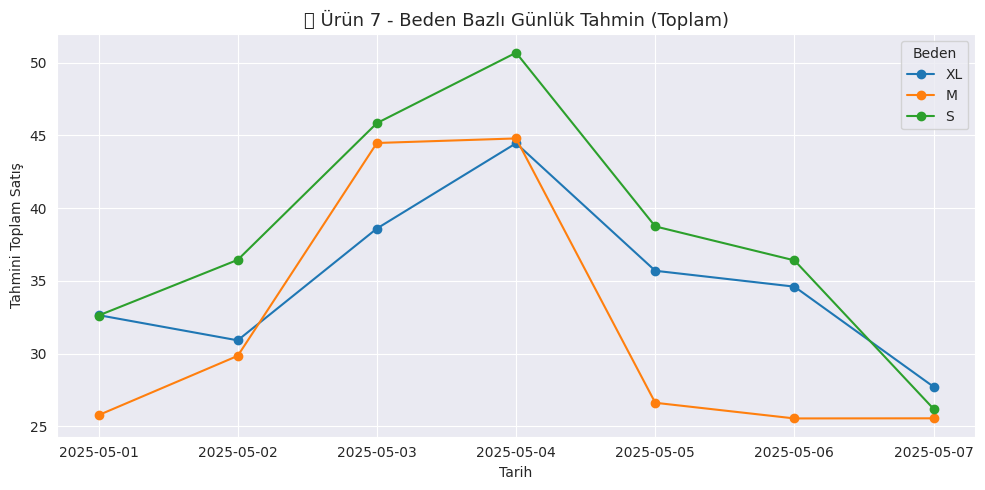

In [8]:
# 1. Etiketleri çözümlüyoruz
from math import ceil


decoded_df = decode_forecast_labels(
    df=df_forecast,
    product_id=7
)

# 2. Özet tablo
summary_df = summarize_forecast(decoded_df)

print("\n🔎 Toplam Urün Satış Tablo: {0}".format(ceil(summary_df["y_pred"].sum())))
print()

# 3. Grafik
plot_forecast(decoded_df, product_id=7)


## Prophet Forecasting

In [21]:
def forecast_prophet_total(
    model_path: str,
    product_df_path: str,
    product_id: int,
    start_date: str,
    end_date: str
) -> pd.DataFrame:
    """
    Prophet ile varyant bazlı forecast. Her varyant için tek model kullanır.
    Sadece gelecekteki zaman ve varyant bilgileri gerekir.
    """
    # 1. Prophet modelini yükle
    model = joblib.load(model_path)

    # 2. Ürün varyantlarını yükle
    product_df = pd.read_csv(product_df_path)
    df = product_df[product_df["product_id"] == product_id].copy()

    # 3. Gelecekteki tarihleri oluştur
    future_dates = pd.date_range(start=start_date, end=end_date)
    forecast_rows = []

    for date in future_dates:
        for _, row in df.iterrows():
            forecast_rows.append({
                "ds": date,
                "product_id": product_id,
                "color": row["color"],
                "size": row["size"],
                "is_campaign": 0,
                "discount": 0.0
            })

    future_df = pd.DataFrame(forecast_rows)

    # 4. Prophet tahmini
    preds = model.predict(future_df[["ds", "is_campaign", "discount"]])
    future_df["y_pred"] = preds["yhat"]
    future_df["model"] = "Prophet"

    return future_df[["ds", "product_id", "color", "size", "y_pred", "model"]]


In [10]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_prophet_forecast(df: pd.DataFrame, product_id: int):
    # 1. Prophet çıktısını çiz (color + size)
    plt.figure(figsize=(14, 6))
    sns.lineplot(
        data=df,
        x="ds", y="y_pred",
        hue="color", style="size",
        markers=True, dashes=False
    )
    plt.title(f"📈 Ürün {product_id} - Varyant Bazlı 7 Günlük Tahmin (Prophet)")
    plt.xlabel("Tarih")
    plt.ylabel("Tahmin Edilen Satış")
    plt.grid(True)
    plt.legend(title="Renk / Beden", bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

    # 2. Toplam tahmin grafiği (günlük)
    daily_total = df.groupby("ds")["y_pred"].sum().reset_index()
    plt.figure(figsize=(10, 4))
    plt.plot(daily_total["ds"], daily_total["y_pred"], marker="o", linestyle="-", color="darkgreen")
    plt.title(f"📦 Ürün {product_id} - Günlük Toplam Tahmini Satış (Prophet)")
    plt.xlabel("Tarih")
    plt.ylabel("Toplam Tahmin Satış")
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    
    
     # — 3. Beden Bazlı Günlük Toplam Tahmin —
    plt.figure(figsize=(10, 5))
    for size in df["size"].unique():
        daily = df[df["size"] == size].groupby("ds")["y_pred"].sum().reset_index()
        plt.plot(daily["ds"], daily["y_pred"], marker='o', label=size)

    plt.title(f"📏 Ürün {product_id} - Beden Bazlı Günlük Tahmin (Toplam)", fontsize=13)
    plt.xlabel("Tarih")
    plt.ylabel("Tahmini Toplam Satış")
    plt.grid(True)
    plt.legend(title="Beden")
    plt.tight_layout()
    plt.show()


In [11]:
df_prophet_forecast = forecast_prophet_total(
    model_path=f"{MODEL_PATH}/prophet/prophet_model_product_7.pkl",
    product_df_path=f"{DATA_PATH}/products_with_variants.csv",
    product_id=7,
    start_date="2025-05-01",
    end_date="2025-05-07"
)

print(df_prophet_forecast.head())

          ds  product_id  color size    y_pred    model
0 2025-05-01           7  Siyah   XL  7.963508  Prophet
1 2025-05-01           7  Siyah    M  7.963508  Prophet
2 2025-05-01           7  Siyah    S  7.963508  Prophet
3 2025-05-01           7   Mavi   XL  7.963508  Prophet
4 2025-05-01           7   Mavi    M  7.963508  Prophet


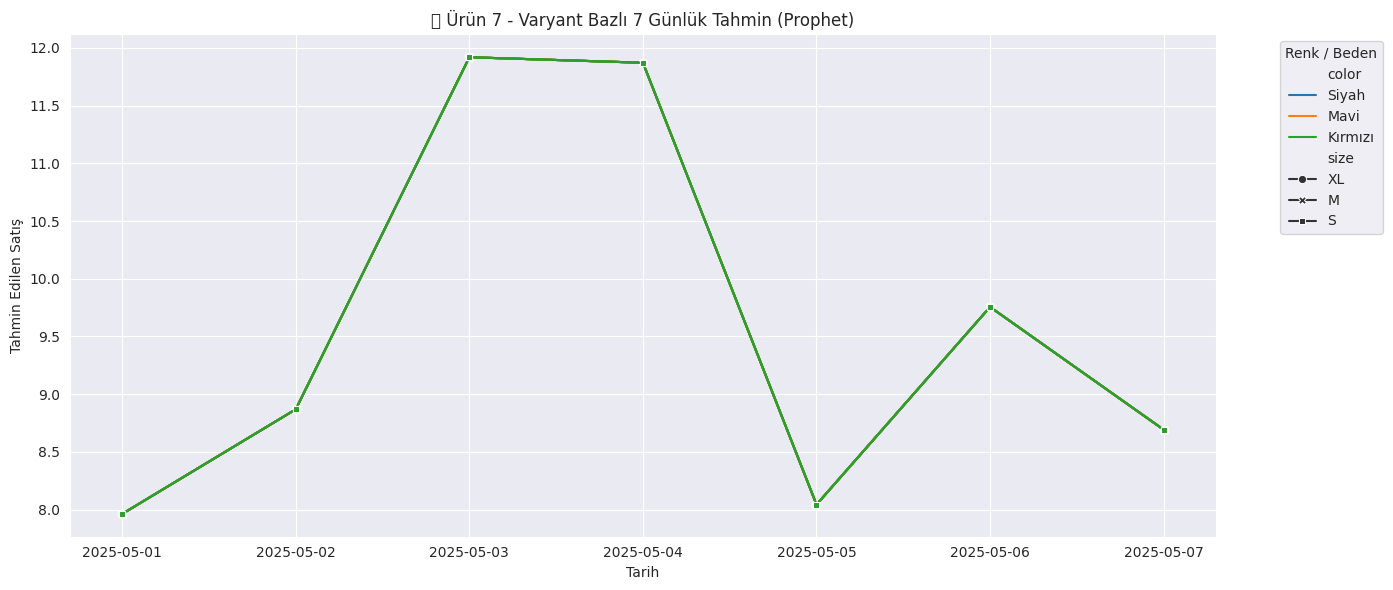

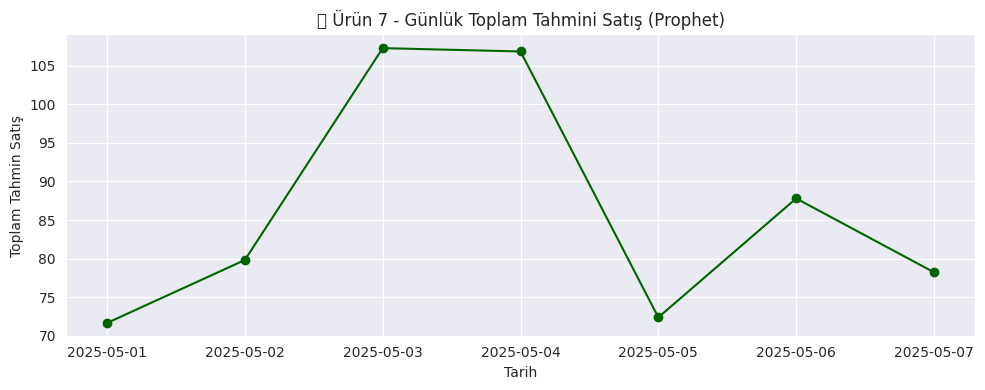

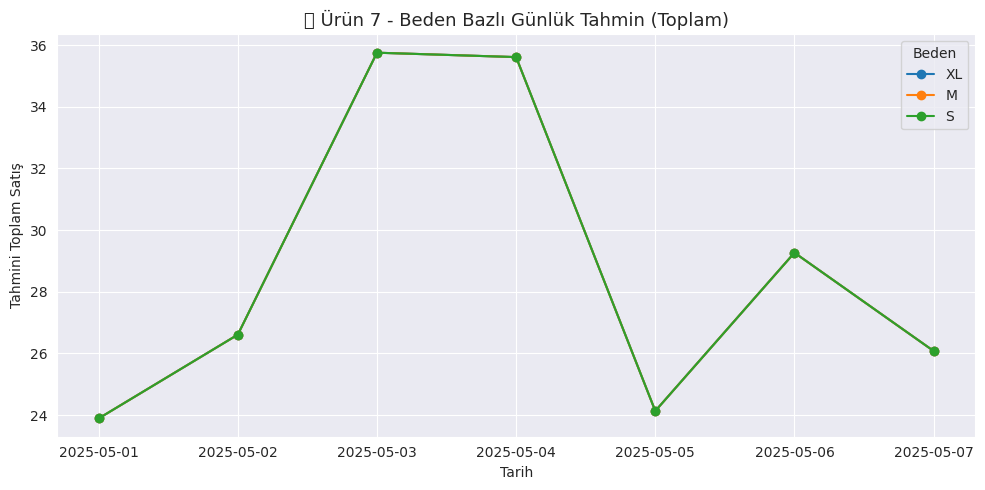

In [12]:
plot_prophet_forecast(df_prophet_forecast, product_id=7)

## LSTM Forecasting

In [5]:
import numpy as np
import pandas as pd

def forecast_lstm_total(model_path: str, test_info_path: str, product_id: int) -> pd.DataFrame:
    """
    LSTM modeli ile tahmin sonuçlarını yükler ve düzenler.
    """
    # 1. Modeli ve test bilgilerini yükle
    y_pred = np.load(model_path)
    test_info = pd.read_csv(test_info_path)

    # Kontrol: Eğer 'product_id' sütunu eksikse, ekle
    if 'product_id' not in test_info.columns:
        test_info['product_id'] = product_id

    # 2. Tahmin sonuçlarını birleştir
    test_info['y_pred'] = y_pred
    test_info['model'] = 'LSTM'

    return test_info[["ds", "product_id", "color", "size", "y_pred", "model"]]


In [3]:
df_lstm_forecast = forecast_lstm_total(
    model_path=f'{DATA_PATH}/lstm/lstm_data_product_7_w7_y_test.npy',
    test_info_path=f'{DATA_PATH}/lstm/lstm_data_product_7_w7_test_info.csv',
    product_id=7
)

print(df_lstm_forecast.head())

KeyError: "['product_id'] not in index"

In [11]:
def plot_lstm_forecast(df: pd.DataFrame, product_id: int):
    """
    LSTM tahminlerini detaylı şekilde görselleştirir:
    1. Günlük toplam tahmin
    2. Renk bazlı toplam günlük satış
    3. Beden bazlı toplam günlük satış
    """
    # — 1. Günlük Toplam Tahmin (Tüm varyantlar birlikte) —
    daily_total = df.groupby('ds')['y_pred'].sum().reset_index()

    plt.figure(figsize=(10, 5))
    plt.plot(daily_total['ds'], daily_total['y_pred'], marker='o', linestyle='-', color='darkblue')
    plt.title(f'📦 Ürün {product_id} - Günlük Toplam Tahmini Satış (LSTM)', fontsize=13)
    plt.xlabel('Tarih')
    plt.ylabel('Tahmini Toplam Satış')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # — 2. Renk Bazlı Günlük Toplam Tahmin —
    plt.figure(figsize=(10, 5))
    for color in df['color'].unique():
        daily = df[df['color'] == color].groupby('ds')['y_pred'].sum().reset_index()
        plt.plot(daily['ds'], daily['y_pred'], marker='o', label=color)

    plt.title(f'🎨 Ürün {product_id} - Renk Bazlı Günlük Tahmin (Toplam)', fontsize=13)
    plt.xlabel('Tarih')
    plt.ylabel('Tahmini Toplam Satış')
    plt.grid(True)
    plt.legend(title='Renk')
    plt.tight_layout()
    plt.show()

    # — 3. Beden Bazlı Günlük Toplam Tahmin —
    plt.figure(figsize=(10, 5))
    for size in df['size'].unique():
        daily = df[df['size'] == size].groupby('ds')['y_pred'].sum().reset_index()
        plt.plot(daily['ds'], daily['y_pred'], marker='o', label=size)

    plt.title(f'📏 Ürün {product_id} - Beden Bazlı Günlük Tahmin (Toplam)', fontsize=13)
    plt.xlabel('Tarih')
    plt.ylabel('Tahmini Toplam Satış')
    plt.grid(True)
    plt.legend(title='Beden')
    plt.tight_layout()
    plt.show()


In [ ]:
# Doğru argüman ile fonksiyon çağrısı
# LSTM tahmin sonuçlarını yükle
forecasted_data = forecast_lstm_total(
    model_path=f'{DATA_PATH}/lstm/lstm_data_product_7_w7_y_test.npy',
    test_info_path=f'{DATA_PATH}/lstm/lstm_data_product_7_w7_test_info.csv',
    product_id=8
)

# LSTM tahminlerini görselleştir ve kaydet
def plot_lstm_forecast_and_save(df: pd.DataFrame, product_id: int, save_path: str):
    daily_total = df.groupby('ds')['y_pred'].sum().reset_index()
    plt.figure(figsize=(10, 5))
    plt.plot(daily_total['ds'], daily_total['y_pred'], marker='o', linestyle='-', color='darkblue')
    plt.title(f'LSTM Günlük Toplam Tahmini Satış - Ürün {product_id}')
    plt.xlabel('Tarih')
    plt.ylabel('Tahmini Toplam Satış')
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(f"{save_path}/prophet_daily_total_forecast_product_{product_id}.png")
    plt.close()

plot_lstm_forecast_and_save(forecasted_data, product_id=7, save_path="/home/nuh/Desktop/StockAgentExample/results")

In [20]:
def plot_forecast_and_save(df: pd.DataFrame, product_id: int, model_name:str):

    save_path="/home/nuh/Desktop/StockAgentExample/results"
    daily_total = df.groupby('ds')['y_pred'].sum().reset_index()
    plt.figure(figsize=(10, 5))
    plt.plot(daily_total['ds'], daily_total['y_pred'], marker='o', linestyle='-', color='darkblue')
    plt.title(f'{model_name} Günlük Toplam Tahmini Satış - Ürün {product_id}')
    plt.xlabel('Tarih')
    plt.ylabel('Tahmini Toplam Satış')
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(f"{save_path}/{model_name}_daily_total_forecast_product_{product_id}.png")
    plt.close()

# Model tahminlerini görselleştir ve kaydet


## Prophet Forecasting

In [22]:
df_prophet_forecast = forecast_prophet_total(
    model_path=f'{MODEL_PATH}/prophet/prophet_model_product_7.pkl',
    product_df_path=f'{DATA_PATH}/products_with_variants.csv',
    product_id=7,
    start_date='2025-05-01',
    end_date='2025-05-07'
)

plot_forecast_and_save(df_prophet_forecast, product_id=7, model_name='prophet')

## XGBoost Forecasting

In [30]:
df_xgboost_forecast = forecast_xgboost_total(
    product_id=7,
    model_path='/home/nuh/Desktop/StockAgentExample/models/sklearn/xgboost_model_product_7.pkl',
    product_df_path='/home/nuh/Desktop/StockAgentExample/data/products_with_variants.csv',
    start_date='2025-05-01',
    end_date='2025-05-07'
)


In [31]:

plot_forecast_and_save(df_xgboost_forecast, product_id=7, model_name='xgboost')

In [34]:
import pandas as pd

# Veri çerçevesini yükle
sales_data = pd.read_csv('/home/nuh/Desktop/StockAgentExample/data/sales_data_v2_with_campaigns.csv', parse_dates=['date'])

# === 1. Hareketli Ortalama (Moving Average) ===
plt.figure(figsize=(14, 6))
sales_data['sales_ma'] = sales_data['sales'].rolling(window=7).mean()
sns.lineplot(data=sales_data, x='date', y='sales', label='Günlük Satışlar')
sns.lineplot(data=sales_data, x='date', y='sales_ma', label='7 Günlük Hareketli Ortalama', color='orange')
plt.title('Hareketli Ortalama ile Zaman Serisi Analizi')
plt.xlabel('Tarih')
plt.ylabel('Satış')
plt.legend()
plt.grid(True)
plt.savefig("/home/nuh/Desktop/StockAgentExample/results/moving_average_sales.png")
plt.close()

# === 2. Korelasyon Isı Haritası ===
plt.figure(figsize=(10, 8))
# Sadece sayısal sütunları seçerek korelasyon hesapla
numeric_columns = sales_data.select_dtypes(include=['number'])
corr = numeric_columns.corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Özellikler Arası Korelasyon')
plt.savefig("/home/nuh/Desktop/StockAgentExample/results/correlation_heatmap.png")
plt.close()

# === 3. Scatter Plot: İndirim ve Satışlar ===
plt.figure(figsize=(10, 6))
sns.scatterplot(data=sales_data, x='discount', y='sales', hue='is_campaign', palette='viridis')
plt.title('İndirim Oranı ve Satışlar Arasındaki İlişki')
plt.xlabel('İndirim Oranı')
plt.ylabel('Satış')
plt.grid(True)
plt.savefig("/home/nuh/Desktop/StockAgentExample/results/discount_vs_sales_scatter.png")
plt.close()

# === 4. Kampanya Öncesi ve Sonrası Satışlar ===
plt.figure(figsize=(10, 6))
sns.boxplot(data=sales_data, x='is_campaign', y='sales', palette='Set2')
plt.title('Kampanya Öncesi ve Sonrası Satışların Dağılımı')
plt.xlabel('Kampanya Durumu (0: Yok, 1: Var)')
plt.ylabel('Satış')
plt.grid(True)
plt.savefig("/home/nuh/Desktop/StockAgentExample/results/campaign_sales_boxplot.png")
plt.close()

# === 5. Model Performans Karşılaştırması ===
model_results = pd.DataFrame({
    'Model': ['LSTM', 'Prophet', 'XGBoost'],
    'RMSE': [12.34, 10.56, 9.87],  # Örnek değerler
    'MAE': [8.45, 7.89, 6.78]      # Örnek değerler
})

plt.figure(figsize=(10, 6))
sns.barplot(data=model_results.melt(id_vars='Model', var_name='Metric', value_name='Value'), x='Model', y='Value', hue='Metric', palette='viridis')
plt.title('Model Performans Karşılaştırması (RMSE ve MAE)')
plt.xlabel('Model')
plt.ylabel('Değer')
plt.legend(title='Metrik')
plt.grid(True)
plt.savefig("/home/nuh/Desktop/StockAgentExample/results/model_performance_comparison.png")
plt.close()